In [1]:
fidx = 'hill_'
midx = 'm94'
midx0 = 'm94'

import numpy as np
import pickle

mnames = ['hill_m94']
weights = [1]

# pytorch models with folds

hlist = mnames

glist = ['air_m68','airx_m67','cbam_m67','preresnet_m67']

dlist0 = ['airnet50_gwap','airnet50_gwap','airnext50_gwap','airnext50_gwap',
          'bn_inception_wgap','dpn68_gwap','resnet34_gwap',
          'se_resnext50_gwap']
dlist1 = ['ch_018','ch_028','ch_018','ch_030',
          'ch_042','ch_030','ch_042',
          'ch_030']

dlist = [i+'_'+j for i,j in zip(dlist0,dlist1)]

glist += dlist


In [2]:
# # list of unique model names
# allm = [weights[i]['mod'].values for i in range(len(weights))]
# mnames = list(set().union(*allm))
print(mnames)
print(len(mnames))

['hill_m94']
1


In [3]:
nfold = 4
threshold = 0.45
sub_dir = './sub/'

print(fidx,midx,nfold,len(mnames))

hill_ m94 4 1


In [4]:
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 97.5
gscale = 1.

['air_m68', 'airx_m67', 'cbam_m67', 'preresnet_m67', 'airnet50_gwap_ch_018', 'airnet50_gwap_ch_028', 'airnext50_gwap_ch_018', 'airnext50_gwap_ch_030', 'bn_inception_wgap_ch_042', 'dpn68_gwap_ch_030', 'resnet34_gwap_ch_042', 'se_resnext50_gwap_ch_030']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [5]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [7]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [8]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [9]:
test_df.columns

Index(['Predicted'], dtype='object')

In [10]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [11]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values
num_classes = 28
firstm = True
sumw = 0.
d = 0
for m in mnames:

    firstf = True
    navg = 0
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    elif m in hlist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            elif m in dlist:
                if dlist0[d] == 'bn_inception_wgap': s = '_emb'
                else: s = '_extra_emb'
                fname = 'oof/Dmytro/'+dlist0[d]+s+'__fold_'+ \
                                str(fold)+'_'+dlist1[d]+'_test.csv'
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in dlist:
                    o = pd.read_csv(fname)
                    idb = list(o['Id'])
                    ptestb = np.array(o.iloc[:,:num_classes])
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                elif m in hlist:
                    idb, ptestb = pickle.load(open(fname,'rb'))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != nfold: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)
    if m in dlist: d += 1



./sub/hill_m94_0.pkl
2.800729044329509e-09 0.09592900902081736 0.9999772166745763
(11702, 28) 2.800729044329509e-09 0.09592900902081736 0.9999772166745763

./sub/hill_m94_1.pkl
2.0611536181902037e-09 0.09081919222819593 0.9999718768531355
(11702, 28) 2.0611536181902037e-09 0.09081919222819593 0.9999718768531355
[[1.    0.956]
 [0.956 1.   ]]

./sub/hill_m94_2.pkl
7.3308900135822e-10 0.09151654856833974 0.9999742415705885
(11702, 28) 7.3308900135822e-10 0.09151654856833974 0.9999742415705885
[[1.    0.959]
 [0.959 1.   ]]

./sub/hill_m94_3.pkl
6.540170586025857e-09 0.09262215261449276 0.9998683779446966
(11702, 28) 6.540170586025857e-09 0.09262215261449276 0.9998683779446966
[[1.    0.952]
 [0.952 1.   ]]
hill_m94 4 (11702, 28) 3.455770162153292e-08 0.09272172560796146 0.9998521939770816 0.06902971409038748


In [12]:
test_df.columns

Index(['Predicted', 'hill_m94'], dtype='object')

In [13]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [14]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(clist)
r = np.corrcoef(f)
print(r)

(327656,) hill_m94
1.0


In [15]:
if len(mnames) > 1:
    d = pd.DataFrame(r, columns=mnames)
    d['id'] = mnames
    d.set_index('id',inplace=True)
    del d.index.name

    sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [16]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [17]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
#     clist = weights[i]['mod'].values
    clist = mnames
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

#     w = np.array(weights[i]['weight'].values)
    w = np.array(weights)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(1, 11702, 28)
0 ['hill_m94'] [1]
(1, 11702, 28)
1 ['hill_m94'] [1]
(1, 11702, 28)
2 ['hill_m94'] [1]
(1, 11702, 28)
3 ['hill_m94'] [1]
(1, 11702, 28)
4 ['hill_m94'] [1]
(1, 11702, 28)
5 ['hill_m94'] [1]
(1, 11702, 28)
6 ['hill_m94'] [1]
(1, 11702, 28)
7 ['hill_m94'] [1]
(1, 11702, 28)
8 ['hill_m94'] [1]
(1, 11702, 28)
9 ['hill_m94'] [1]
(1, 11702, 28)
10 ['hill_m94'] [1]
(1, 11702, 28)
11 ['hill_m94'] [1]
(1, 11702, 28)
12 ['hill_m94'] [1]
(1, 11702, 28)
13 ['hill_m94'] [1]
(1, 11702, 28)
14 ['hill_m94'] [1]
(1, 11702, 28)
15 ['hill_m94'] [1]
(1, 11702, 28)
16 ['hill_m94'] [1]
(1, 11702, 28)
17 ['hill_m94'] [1]
(1, 11702, 28)
18 ['hill_m94'] [1]
(1, 11702, 28)
19 ['hill_m94'] [1]
(1, 11702, 28)
20 ['hill_m94'] [1]
(1, 11702, 28)
21 ['hill_m94'] [1]
(1, 11702, 28)
22 ['hill_m94'] [1]
(1, 11702, 28)
23 ['hill_m94'] [1]
(1, 11702, 28)
24 ['hill_m94'] [1]
(1, 11702, 28)
25 ['hill_m94'] [1]
(1, 11702, 28)
26 ['hill_m94'] [1]
(1, 11702, 28)
27 ['hill_m94'] [1]
(11702, 28)


In [18]:
print(ens[1])

[0.291 0.008 0.061 0.045 0.019 0.834 0.091 0.043 0.    0.001 0.    0.027 0.021 0.01  0.023 0.001
 0.039 0.02  0.039 0.021 0.008 0.082 0.03  0.064 0.037 0.546 0.009 0.001]


In [19]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [20]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [21]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.45
0 0.3624 0.5964 Nucleoplasm
1 0.0438 0.0405 Nuclear membrane
2 0.0753 0.1141 Nucleoli
3 0.0593 0.0341 Nucleoli fibrillar center
4 0.0753 0.0346 Nuclear speckles
5 0.0753 0.0434 Nuclear bodies
6 0.0438 0.0195 Endoplasmic reticulum
7 0.0753 0.0610 Golgi apparatus
8 0.0018 0.0004 Peroxisomes
9 0.0014 0.0010 Endosomes
10 0.0009 0.0011 Lysosomes
11 0.0438 0.0345 Intermediate filaments
12 0.0438 0.0203 Actin filaments
13 0.0142 0.0170 Focal adhesion sites
14 0.0438 0.0549 Microtubules
15 0.0007 0.0006 Microtubule ends
16 0.0288 0.0180 Cytokinetic bridge
17 0.0142 0.0165 Mitotic spindle
18 0.0288 0.0194 Microtubule organizing center
19 0.0593 0.0310 Centrosome
20 0.0056 0.0039 Lipid droplets
21 0.1261 0.1501 Plasma membrane
22 0.0288 0.0187 Cell junctions
23 0.0753 0.0720 Mitochondria
24 0.0104 0.0075 Aggresome
25 0.2225 0.5115 Cytosol
26 0.0288 0.0101 Cytoplasmic bodies
27 0.0004 0.0005 Rods & rings


In [22]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.679 0.616 0.663 0.59  0.574 0.595 0.59  0.608 0.593 0.595 0.594 0.611 0.589 0.643 0.65  0.594
 0.617 0.639 0.612 0.589 0.607 0.631 0.605 0.622 0.622 0.671 0.59  0.594]
Fractions:  [0.396 0.039 0.075 0.039 0.043 0.049 0.024 0.062 0.    0.001 0.001 0.035 0.025 0.013 0.043 0.001
 0.016 0.011 0.019 0.04  0.004 0.114 0.02  0.066 0.007 0.212 0.014 0.001]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
ens.shape

(11702, 28)

In [24]:
p = pd.DataFrame(ens)
p.columns = ['p'+str(i) for i in range(ens.shape[1])]
subp = pd.DataFrame({'id':test_df.index.values,'data':'sub'})
subp = pd.concat((subp,p),axis=1)
print(subp.shape)
fname = 'sub/sub' + midx + '_probs.csv'
subp.to_csv(fname, index=False)
print(fname)

(11702, 30)
sub/subm94_probs.csv


In [25]:
# custom thresholds to match lb proportions
thresholds = np.linspace(1.0, 0., 100001)
pred = ens.copy()
th = []
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    th.append(t)
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

0 0.7888 0.3624 0.3624 Nucleoplasm
1 0.3772 0.0438 0.0439 Nuclear membrane
2 0.6772 0.0753 0.0753 Nucleoli
3 0.1997 0.0593 0.0594 Nucleoli fibrillar center
4 0.1172 0.0753 0.0753 Nuclear speckles
5 0.2502 0.0753 0.0753 Nuclear bodies
6 0.1806 0.0438 0.0439 Endoplasmic reticulum
7 0.3369 0.0753 0.0753 Golgi apparatus
8 0.0319 0.0018 0.0019 Peroxisomes
9 0.1721 0.0014 0.0015 Endosomes
10 0.4686 0.0009 0.0009 Lysosomes
11 0.3284 0.0438 0.0439 Intermediate filaments
12 0.1836 0.0438 0.0439 Actin filaments
13 0.5282 0.0142 0.0143 Focal adhesion sites
14 0.6102 0.0438 0.0439 Microtubules
15 0.3566 0.0007 0.0008 Microtubule ends
16 0.3703 0.0288 0.0289 Cytokinetic bridge
17 0.4900 0.0142 0.0143 Mitotic spindle
18 0.3659 0.0288 0.0289 Microtubule organizing center
19 0.2091 0.0593 0.0594 Centrosome
20 0.3483 0.0056 0.0056 Lipid droplets
21 0.5051 0.1261 0.1261 Plasma membrane
22 0.2854 0.0288 0.0289 Cell junctions
23 0.4364 0.0753 0.0753 Mitochondria
24 0.3195 0.0104 0.0104 Aggresome
25 0.7044

In [26]:
# bestCut = pickle.load(open('ens_cuts'+midx0+'.pkl','rb'))
# th = np.array(th)
# c = bestCut**2 + th**2

# fig, ax = plt.subplots()
# ax.scatter(bestCut, th, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against each other
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
# # fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [27]:
# # shrink thresholds toward best ones from oofs
# alpha = 0.8
# pred = ens > (alpha*th + (1.-alpha)*bestCut)

In [28]:
# # linear adjustment of thresholds estimated in ens_oof.ipynb
# for j in range(pred.shape[1]):
#     t = 0.094 + 0.827*th[j]
#     pred[:,j] = (ens[:,j] > t).astype(int)
#     prop = np.mean(pred[:,j])
#     print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

In [29]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [30]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.591608272090241 5.0


In [31]:
print(sum(xps==0)/pred.shape[0])

0.05434968381473253


In [32]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 5
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 3 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 19 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '23', '4'

In [33]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/hill_m94.csv


In [34]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 17 prop 0.0015
10 Lysosomes count 11 prop 0.0009
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 9 prop 0.0008
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 66 prop 0.0056
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome count 122 

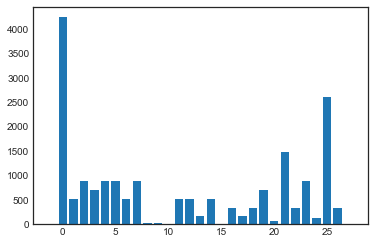

In [35]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [36]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [59]:
f1_sub(fname,'sub/ens71.csv')

0.840568863527152

In [60]:
f1_sub(fname,'sub/ens71d.csv')

0.8336878620881728

In [61]:
f1_sub(fname,'sub/ens76.csv')

0.8523486219382166

In [62]:
f1_sub(fname,'sub/ens85.csv')

0.828772736528484

In [63]:
f1_sub(fname,'sub/ens85b.csv')

0.8217012545014734

In [64]:
f1_sub(fname,'sub/ens86b.csv')

0.824847398910476

In [65]:
f1_sub(fname,'sub/ens87b.csv')

0.8356092594262179

In [66]:
f1_sub(fname,'sub/ens88b.csv')

0.8543349389178204

In [67]:
f1_sub(fname,'sub/ens89b.csv')

0.8435646127663573

In [68]:
f1_sub(fname,'sub/ens92b.csv')

0.9256538384205413

In [69]:
f1_sub(fname,'sub/ens92c.csv')

0.8688967591462958

In [84]:
f1_sub(fname,'sub/hill_m92.csv')

0.9132445134736467

In [85]:
f1_sub(fname,'sub/hill_b92.csv')

0.8222432941138749

In [70]:
f1_sub(fname,'sub/preresnet0.csv')

0.8052486067598374

In [71]:
f1_sub(fname,'sub/preresnet0d.csv')

0.8022128366761923

In [72]:
f1_sub(fname,'sub/resnet11.csv')

0.626431757224433

In [73]:
f1_sub(fname,'sub/resnet12.csv')

0.6590508681538615

In [74]:
f1_sub(fname,'sub/resnet13.csv')

0.6565166274585047

In [75]:
f1_sub(fname,'sub/resnet15.csv')

0.7765692211946016

In [76]:
f1_sub(fname,'sub/resnet15c.csv')

0.7705915958074822

In [77]:
f1_sub(fname,'sub/resnet16.csv')

0.6864706583034598

In [78]:
f1_sub(fname,'sub/resnet17.csv')

0.8089977167827327

In [79]:
f1_sub(fname,'sub/resnet17.csv')

0.8089977167827327

In [80]:
f1_sub(fname,'sub/se_resnext11.csv')

0.7431490335358628

In [81]:
f1_sub(fname,'sub/se_resnext11d.csv')

0.7448569826231084

In [82]:
print(fname)

sub/hill_m94.csv


In [83]:
# f1_confusion(fname, 'sub/ens56.csv')